In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

from nata.containers import GridDataset
from nata.containers import GridArray
from nata.containers import Axis
from nata.plugins.register import register_container_plugin

# Slice

The grid `.slice()` plugin returns a lower dimensionality slice of the original `GridArray` or `GridDataset`.

In [3]:
grid = GridArray.from_array(
    np.arange(96).reshape((8, 4, 3))
)
grid


| **GridArray** | |
| ---: | :--- |
| **name**  | unnamed |
| **label** | unlabeled |
| **unit**  | '' |
| **shape** | (8, 4, 3) |
| **dtype** | int64 |
| **time**  | 0.0 |
| **axes**  | Axis(axis0), Axis(axis1), Axis(axis2) |



Both the axis name or its index can be used to select the slicing direction.

In [4]:
sliced_grid = grid.slice(constant="axis0", value=0)
sliced_grid.shape

(4, 3)

In [5]:
sliced_grid = grid.slice(constant=0, value=0)
sliced_grid.shape

(4, 3)

When using axis indices, negative values are also supported.

In [6]:
sliced_grid = grid.slice(constant=-1, value=0)
sliced_grid.shape

(8, 4)

When slicing `GridDataset`, time dependence is always preserved.

In [7]:
grid = GridDataset.from_array(
    np.arange(96).reshape((8, 4, 3))
)
grid


| **GridDataset** | |
| ---: | :--- |
| **name**  | unnamed |
| **label** | unlabeled |
| **unit**  | '' |
| **shape** | (8, 4, 3) |
| **dtype** | int64 |
| **time**  | [0 1 2 3 4 5 6 7] |
| **axes**  | Axis(time), Axis(axis0), Axis(axis1) |



In [8]:
sliced_grid = grid.slice(constant="axis0", value=0)
sliced_grid


| **GridDataset** | |
| ---: | :--- |
| **name**  | unnamed |
| **label** | unlabeled |
| **unit**  | '' |
| **shape** | (8, 3) |
| **dtype** | int64 |
| **time**  | [0. 0. 0. 0. 0. 0. 0. 0.] |
| **axes**  | Axis(time), Axis(axis1) |



Slices are not allowed along the time axis.

In [9]:
try:
    grid.slice(constant="time", value=0)
except ValueError:
    print("slice along the time axis `time` is not supported")

slice along the time axis `time` is not supported


Slices are allowed along moving axis as long as the value at which they are taken exists in the corresponding axis for all times.

In [10]:
x = np.arange(10)
grid = GridDataset.from_array(
    np.tile(x, (5, 1)), 
    axes=[
        Axis(np.arange(5), name="t"), 
        Axis([x, x+1, x+2, x+3, x+4], name="x1"),
    ]
)
grid.slice(constant="x1", value=5)


| **GridDataset** | |
| ---: | :--- |
| **name**  | unnamed |
| **label** | unlabeled |
| **unit**  | '' |
| **shape** | (5,) |
| **dtype** | int64 |
| **time**  | [0. 0. 0. 0. 0.] |
| **axes**  | Axis(time) |



# Fast Fourier Transform (FFT)

The grid `.fft()` plugin returns the FFT of the original `GridDataset`.

If the `comp` argument is not provided, `.fft()` returns the absolute value of the FFT.

In [11]:
x = np.linspace(0, 10*np.pi, 101)

grid = GridArray.from_array(
    np.sin(x),
    name="dataset",
    unit="A",
    axes=[
        Axis(x, name="x1", label="x_1", unit="a")
    ]
)
fft_grid = grid.fft()
fft_grid


| **GridArray** | |
| ---: | :--- |
| **name**  | dataset |
| **label** | |unlabeled| |
| **unit**  | A |
| **shape** | (101,) |
| **dtype** | float64 |
| **time**  | 0.0 |
| **axes**  | Axis(k_x1) |



The axes over which the FFT is computed are transformed such thatthe zero frequency bins are centered.

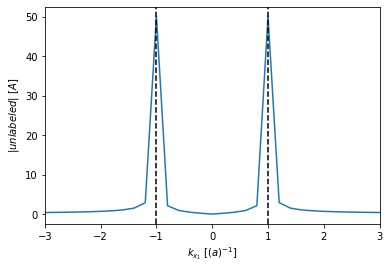

In [12]:
fig, ax = plt.subplots()

ax.plot(fft_grid.axes[0].to_dask(), fft_grid.to_dask())
ax.set_xlim((-3, 3))
ax.set_xlabel(f"${fft_grid.axes[0].label}$ [${fft_grid.axes[0].unit}$]")
ax.set_ylabel(f"${fft_grid.label}$ [${fft_grid.unit}$]")
ax.axvline(+1, c="k", ls="--")
ax.axvline(-1, c="k", ls="--")
fig.show()

If `comp` is provided, `.fft()` returns the corresponding component of the FFT.

In [13]:
fft_grid = grid.fft(comp="imag")
fft_grid


| **GridArray** | |
| ---: | :--- |
| **name**  | dataset |
| **label** | \Im(unlabeled) |
| **unit**  | A |
| **shape** | (101,) |
| **dtype** | float64 |
| **time**  | 0.0 |
| **axes**  | Axis(k_x1) |



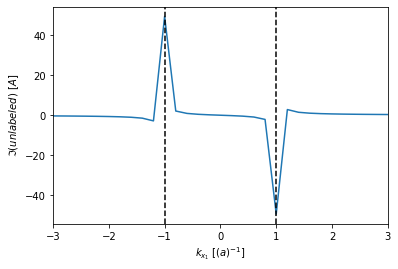

In [14]:
fig, ax = plt.subplots()

ax.plot(fft_grid.axes[0].to_dask(), fft_grid.to_dask())
ax.set_xlim((-3, 3))
ax.set_xlabel(f"${fft_grid.axes[0].label}$ [${fft_grid.axes[0].unit}$]")
ax.set_ylabel(f"${fft_grid.label}$ [${fft_grid.unit}$]")
ax.axvline(+1, c="k", ls="--")
ax.axvline(-1, c="k", ls="--")
fig.show()

When applied to multidimensional grids, the `axes` argument controls the axes over which the FFT is computed. If `axes` is not provided, the FFT is computed over all available grid axes.

In [15]:
x = np.linspace(0, 10*np.pi, 101)
y = np.linspace(0, 10*np.pi, 201)

X,Y = np.meshgrid(x, y, indexing="ij")

grid = GridArray.from_array(
    np.sin(X) + np.sin(2*Y),
    name="dataset",
    axes=[
        Axis(x, name="x1", label="x_1", unit="a"),
        Axis(y, name="x2", label="x_2", unit="b")
    ]
)
fft_grid = grid.fft()
fft_grid


| **GridArray** | |
| ---: | :--- |
| **name**  | dataset |
| **label** | |unlabeled| |
| **unit**  | '' |
| **shape** | (101, 201) |
| **dtype** | float64 |
| **time**  | 0.0 |
| **axes**  | Axis(k_x1), Axis(k_x2) |



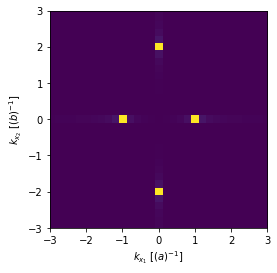

In [16]:
fig, ax = plt.subplots()

im = ax.imshow(
    np.transpose(fft_grid.to_dask()), 
    extent=(
        np.min(fft_grid.axes[0].to_dask()),
        np.max(fft_grid.axes[0].to_dask()),
        np.min(fft_grid.axes[1].to_dask()),
        np.max(fft_grid.axes[1].to_dask())
    ),
    origin="lower",
)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

ax.set_xlabel(f"${fft_grid.axes[0].label}$ [${fft_grid.axes[0].unit}$]")
ax.set_ylabel(f"${fft_grid.axes[1].label}$ [${fft_grid.axes[1].unit}$]")

fig.show()

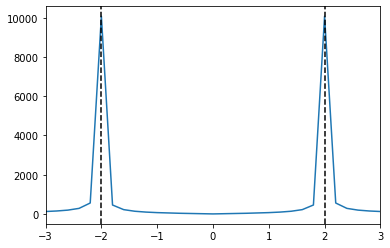

In [17]:
fig, ax = plt.subplots()

ax.plot(fft_grid.axes[1].to_dask(), fft_grid.to_dask()[50, :])
ax.set_xlim((-3, 3))
ax.axvline(+2, c="k", ls="--")
ax.axvline(-2, c="k", ls="--")
fig.show()

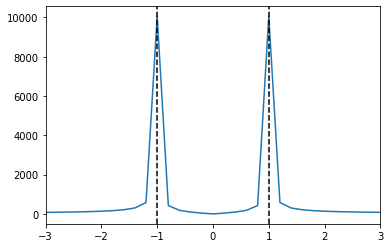

In [18]:
fig, ax = plt.subplots()

ax.plot(fft_grid.axes[0].to_dask(), fft_grid.to_dask()[:, 100])
ax.set_xlim((-3, 3))
ax.axvline(+1, c="k", ls="--")
ax.axvline(-1, c="k", ls="--")
fig.show()

If `axes` is provided, the FFT is only computed over the identified grid axes. Both strings (corresponding to axes names) and integers can be provided in `axes`.

In [19]:
fft_grid = grid.fft(axes=["x2"])
fft_grid


| **GridArray** | |
| ---: | :--- |
| **name**  | dataset |
| **label** | |unlabeled| |
| **unit**  | '' |
| **shape** | (101, 201) |
| **dtype** | float64 |
| **time**  | 0.0 |
| **axes**  | Axis(x1), Axis(k_x2) |



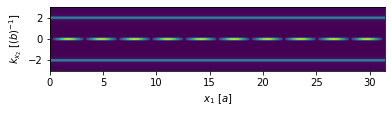

In [20]:
fig, ax = plt.subplots()

im = ax.imshow(
    np.transpose(fft_grid.to_numpy()), 
    extent=(
        np.min(fft_grid.axes[0].to_dask()),
        np.max(fft_grid.axes[0].to_dask()),
        np.min(fft_grid.axes[1].to_dask()),
        np.max(fft_grid.axes[1].to_dask())
    ),
    origin="lower",
)
ax.set_ylim(-3, 3)

ax.set_xlabel(f"${fft_grid.axes[0].label}$ [${fft_grid.axes[0].unit}$]")
ax.set_ylabel(f"${fft_grid.axes[1].label}$ [${fft_grid.axes[1].unit}$]")

fig.show()

In [21]:
time = np.arange(3)
x = np.linspace(0, 10*np.pi, 101)

grid = GridDataset.from_array(
    [np.sin(x), np.sin(2*x), np.sin(3*x)],
    name="dataset",
    label="S",
    unit="A",
    axes=[
        Axis(time),
        Axis(np.tile(x, (3, 1)), name="x1", label="x_1", unit="a")
    ]
)
fft_grid = grid.fft(comp="abs")
fft_grid


| **GridDataset** | |
| ---: | :--- |
| **name**  | dataset |
| **label** | |S| |
| **unit**  | A |
| **shape** | (3, 101) |
| **dtype** | float64 |
| **time**  | [0. 0. 0.] |
| **axes**  | Axis(time), Axis(k_x1) |



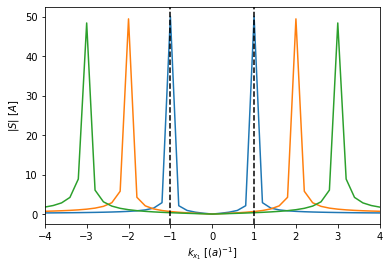

In [22]:
fig, ax = plt.subplots()

for fft_grid_i in fft_grid:
    ax.plot(fft_grid_i.axes[0].to_dask(), fft_grid_i.to_dask())
ax.set_xlim((-4, 4))
ax.set_xlabel(f"${fft_grid.axes[1].label}$ [${fft_grid.axes[1].unit}$]")
ax.set_ylabel(f"${fft_grid.label}$ [${fft_grid.unit}$]")
ax.axvline(+1, c="k", ls="--")
ax.axvline(-1, c="k", ls="--")
fig.show()